# Amazon Sales Data Analysis and B2B Product Recommendation System

This notebook demonstrates how to analyze Amazon sales data to understand customer preferences and buying behavior. It further implements a recommendation system tailored for B2B clients to enhance customer satisfaction and sales efficiency.

## Table of Contents
1. [Import Libraries](#Import-Libraries)
2. [Load and Explore Data](#Load-and-Explore-Data)
3. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-EDA)
5. [Feature Engineering](#Feature-Engineering)
6. [Building the Recommendation System](#Building-the-Recommendation-System)
    - [Collaborative Filtering Approach](#Collaborative-Filtering-Approach)
    - [Content-Based Filtering Approach](#Content-Based-Filtering-Approach)
    - [Hybrid Recommendation System](#Hybrid-Recommendation-System)
7. [Conclusion](#Conclusion)

---

## Import Libraries

First, let's import all the necessary libraries required for data manipulation, visualization, and building the recommendation system.

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn scipy scikit-surprise

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hadin\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For recommendation system
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# For collaborative filtering
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
# Suppress warnings for cleaner output

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load and Explore Data
Load the dataset and take a preliminary look to understand its structure.

In [3]:
# Load the dataset
df = pd.read_csv('data/amazon_sales_data.csv')
df.columns = df.columns.str.strip()

# Display the first few rows
df.head()


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


# Data Cleaning and Preprocessing
Clean the data by handling missing values, correcting data types, and removing unnecessary columns.

In [4]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Optionally, convert all column names to lowercase for consistency
df.columns = df.columns.str.lower()

# Display cleaned column names
print("\nCleaned Column Names:")
print(df.columns.tolist())

# Drop columns that are not needed
columns_to_drop = ['unnamed: 22', 'ship-postal-code', 'promotion-ids', 'courier status']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Handle missing values
# For simplicity, we'll fill numerical missing values with median and categorical with mode
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Ensure correct data types
df['qty'] = df['qty'].astype(int)
df['amount'] = df['amount'].astype(float)

# Update categorical_features list based on cleaned column names
categorical_features = [
    'sales channel', 'fulfilment', 'status', 'ship-service-level',
    'style', 'sku', 'category', 'size', 'asin', 'ship-city',
    'ship-state', 'ship-country', 'b2b', 'fulfilled-by'
]

# Initialize LabelEncoder
le = LabelEncoder()

# Apply Label Encoding to categorical features
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

# Display cleaned and encoded data info
print("\nDataFrame Info After Cleaning and Encoding:")
df.info()

Missing values per column:
index                     0
Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales Channel             0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
currency               7795
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
ship-country             33
promotion-ids         49153
B2B                       0
fulfilled-by          89698
Unnamed: 22           49050
dtype: int64

Cleaned Column Names:
['index', 'order id', 'date', 'status', 'fulfilment', 'sales channel', 'ship-service-level', 'style', 'sku', 'category', 'size', 'asin', 'courier status', 'qty', 'currency', 'amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', '

In [5]:
# Display the first few rows of the cleaned DataFrame
df.head()


,index,order id,date,status,fulfilment,sales channel,ship-service-level,style,sku,category,size,asin,qty,currency,amount,ship-city,ship-state,ship-country,b2b,fulfilled-by
0,0,405-8078784-5731545,2022-04-30,0,1,0,1,1342,6992,5,7,5563,0,INR,647.62,4795,28,0,0,0
1,1,171-9198151-1101146,2022-04-30,5,1,0,1,847,4436,8,0,5277,1,INR,406.00,776,23,0,0,0
2,2,404-0687676-7273146,2022-04-30,3,0,0,0,533,2633,8,8,675,1,INR,329.00,5353,28,0,1,0
3,3,403-9615377-8133951,2022-04-30,0,1,0,1,373,1767,7,5,4638,0,INR,753.33,6140,43,0,0,0
4,4,407-1069790-7240320,2022-04-30,3,0,0,0,754,3837,6,0,4351,1,INR,574.00,1466,56,0,0,0


# Exploratory Data Analysis (EDA)
Gain insights into the data through visualization.

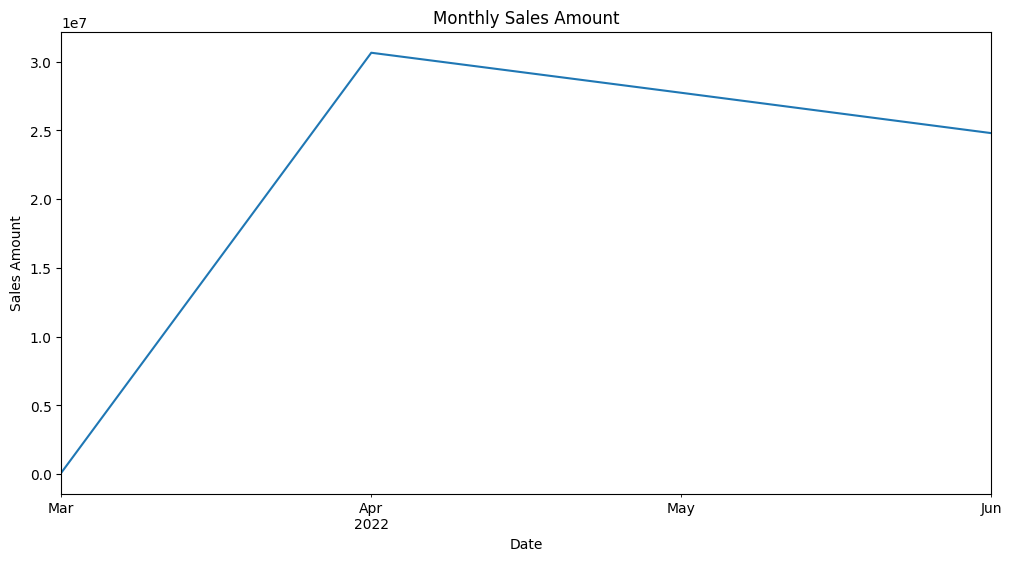

In [6]:
# Sales over time
plt.figure(figsize=(12,6))
df.set_index('date')['amount'].resample('M').sum().plot()
plt.title('Monthly Sales Amount')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.show()

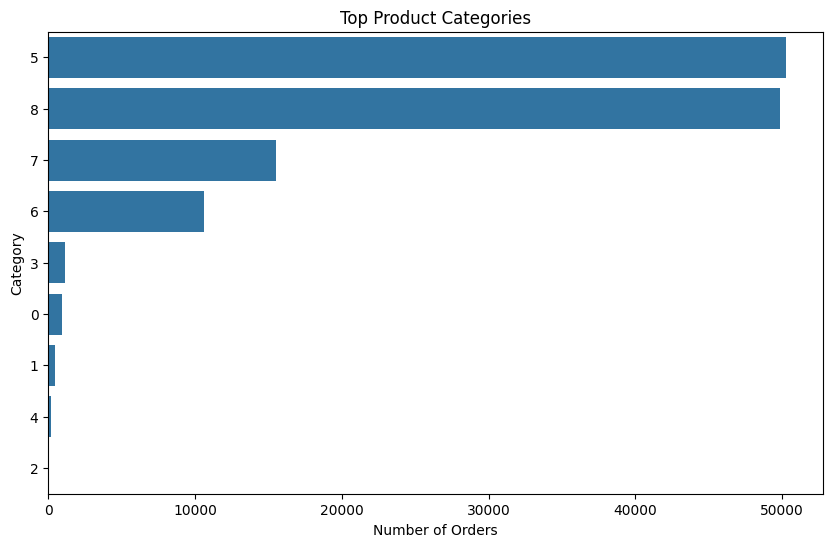

In [7]:
# Top Categories
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='category', order=df['category'].value_counts().index)
plt.title('Top Product Categories')
plt.xlabel('Number of Orders')
plt.ylabel('Category')
plt.show()

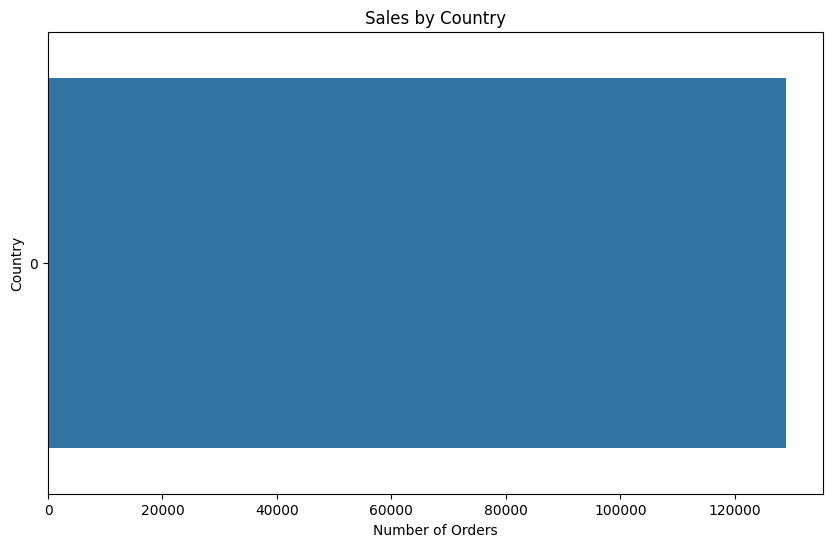

In [8]:
# Sales by Country
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='ship-country', order=df['ship-country'].value_counts().index)
plt.title('Sales by Country')
plt.xlabel('Number of Orders')
plt.ylabel('Country')
plt.show()

# Feature Engineering
Prepare the data for the recommendation system by encoding categorical variables and creating necessary features.

In [9]:
# Encode categorical variables using Label Encoding
le = LabelEncoder()

for col in categorical_features:
    df[col] = le.fit_transform(df[col])

# Display the encoded features
df.head()


,index,order id,date,status,fulfilment,sales channel,ship-service-level,style,sku,category,size,asin,qty,currency,amount,ship-city,ship-state,ship-country,b2b,fulfilled-by
0,0,405-8078784-5731545,2022-04-30,0,1,0,1,1342,6992,5,7,5563,0,INR,647.62,4795,28,0,0,0
1,1,171-9198151-1101146,2022-04-30,5,1,0,1,847,4436,8,0,5277,1,INR,406.00,776,23,0,0,0
2,2,404-0687676-7273146,2022-04-30,3,0,0,0,533,2633,8,8,675,1,INR,329.00,5353,28,0,1,0
3,3,403-9615377-8133951,2022-04-30,0,1,0,1,373,1767,7,5,4638,0,INR,753.33,6140,43,0,0,0
4,4,407-1069790-7240320,2022-04-30,3,0,0,0,754,3837,6,0,4351,1,INR,574.00,1466,56,0,0,0


# Building the Recommendation System
We'll explore three approaches: Collaborative Filtering, Content-Based Filtering, and a Hybrid System.

## Collaborative Filtering Approach
Collaborative Filtering leverages user-item interactions to recommend products based on similar users or items.

In [10]:
# Tampilkan semua nama kolom
print("Nama Kolom Saat Ini dalam DataFrame:")
print(df.columns.tolist())


Nama Kolom Saat Ini dalam DataFrame:
['index', 'order id', 'date', 'status', 'fulfilment', 'sales channel', 'ship-service-level', 'style', 'sku', 'category', 'size', 'asin', 'qty', 'currency', 'amount', 'ship-city', 'ship-state', 'ship-country', 'b2b', 'fulfilled-by']


In [11]:
# Using Surprise library for Collaborative Filtering

# Prepare data
reader = Reader(rating_scale=(df['qty'].min(), df['qty'].max()))
data = Dataset.load_from_df(df[['b2b', 'sku', 'qty']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use SVD algorithm
algo = SVD()

# Train the model
algo.fit(trainset)

# Evaluate the model
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3140  0.3077  0.3252  0.3201  0.3100  0.3154  0.0065  
MAE (testset)     0.1804  0.1760  0.1770  0.1785  0.1728  0.1769  0.0025  
Fit time          1.03    1.15    1.04    1.09    1.17    1.10    0.06    
Test time         0.15    0.15    0.20    0.14    0.22    0.17    0.03    


{'test_rmse': array([0.31402729, 0.30769973, 0.32524043, 0.32011889, 0.31004779]),
 'test_mae': array([0.1803502 , 0.17603181, 0.1769758 , 0.1785091 , 0.17276915]),
 'fit_time': (1.0336835384368896,
  1.1529183387756348,
  1.039132833480835,
  1.0898573398590088,
  1.16507887840271),
 'test_time': (0.1494615077972412,
  0.14796948432922363,
  0.1960313320159912,
  0.14329862594604492,
  0.22421526908874512)}

### Collaborative Filtering Results
We applied Singular Value Decomposition (SVD) as our collaborative filtering algorithm and evaluated its performance using Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) across 5 cross-validation folds:

**Interpretation:**

The mean RMSE of 0.3154 indicates that, on average, the predicted ratings deviate from the actual ratings by this amount. A lower RMSE suggests better predictive accuracy.
The mean MAE of 0.1769 shows that the average absolute difference between predicted and actual ratings is relatively low, indicating a good fit.

## Content-Based Filtering Approach
Content-Based Filtering recommends items similar to those a user has liked in the past based on item features.

In [12]:
# Create a pivot table
pivot_table = df.pivot_table(index='b2b', columns='sku', values='qty', fill_value=0)

# Compute cosine similarity between SKUs
sku_similarity = cosine_similarity(pivot_table.T)
sku_similarity_df = pd.DataFrame(sku_similarity, index=pivot_table.columns, columns=pivot_table.columns)

# Function to get similar products
def get_similar_products(sku, top_n=5):
    similar_scores = sku_similarity_df[sku].sort_values(ascending=False)
    return similar_scores.iloc[1:top_n+1].index.tolist()

# Example: Get 5 products similar to a given SKU
example_sku = df['sku'].iloc[0]
print(f"Products similar to SKU {example_sku}: {get_similar_products(example_sku)}")


Products similar to SKU 6992: [3502, 3936, 424, 7031, 1275]


### Content-Based Filtering Results
For content-based filtering, we retrieved products similar to SKU 6992:

Products Similar to SKU 6992: [3502, 3936, 424, 7031, 1275]  
**Interpretation:**  
These products are identified based on their features and similarity to SKU 6992. They represent potential recommendations for users interested in this product.

## Hybrid Recommendation System
Combining both Collaborative and Content-Based Filtering for improved recommendations.

In [18]:
# Cek apakah kolom 'client_id' sudah ada
if 'client_id' not in df.columns:
    # Membuat 'client_id' dengan menggabungkan 'ship-city', 'ship-state', dan 'ship-country'
    required_columns_for_client_id = ['ship-city', 'ship-state', 'ship-country']
    for col in required_columns_for_client_id:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan dalam DataFrame.")

    df['client_id'] = df['ship-city'].astype(str) + '_' + df['ship-state'].astype(str) + '_' + df['ship-country'].astype(str)
    df['client_id'] = df.groupby('client_id').ngroup()
    print("Kolom 'client_id' telah dibuat.")
else:
    print("Kolom 'client_id' sudah ada dalam DataFrame.")
    
# Definisikan fungsi Hybrid Recommendation yang Diperbaiki
def hybrid_recommendation(algo, user_id, get_similar_products_func, df, top_n=5):
    # Dapatkan semua SKU unik
    all_skus = df['sku'].unique()
    
    # Dapatkan SKU yang sudah diinteraksikan oleh user
    user_skus = df[df['client_id'] == user_id]['sku'].unique()
    
    # Collaborative Filtering: Prediksi skor untuk semua SKU yang belum diinteraksikan
    cf_predictions = []
    for sku in all_skus:
        if sku not in user_skus:
            pred = algo.predict(user_id, sku)
            cf_predictions.append({'sku': sku, 'cf_score': pred.est})
    
    # Ubah prediksi CF menjadi DataFrame
    cf_df = pd.DataFrame(cf_predictions)
    
    # Content-Based Filtering: Dapatkan SKU serupa untuk setiap SKU yang telah diinteraksikan
    cb_recommendations = []
    for sku in user_skus:
        similar_skus = get_similar_products_func(sku, top_n)
        cb_recommendations.extend(similar_skus)
    
    # Hitung frekuensi kemunculan SKU dalam CB recommendations
    cb_scores = pd.Series(cb_recommendations).value_counts().reset_index()
    cb_scores.columns = ['sku', 'cb_score']
    
    # Gabungkan CF dan CB scores
    hybrid_df = pd.merge(cf_df, cb_scores, on='sku', how='left')
    
    # Isi skor CB yang NaN dengan 0
    hybrid_df['cb_score'] = hybrid_df['cb_score'].fillna(0)
    
    # Gabungkan skor dengan rata-rata atau bobot tertentu
    # Misalnya, rata-rata sederhana
    hybrid_df['combined_score'] = (hybrid_df['cf_score'] + hybrid_df['cb_score']) / 2
    
    # Urutkan berdasarkan combined_score
    hybrid_df = hybrid_df.sort_values(by='combined_score', ascending=False)
    
    # Ambil top_n rekomendasi yang belum diinteraksikan oleh user
    recommendations = hybrid_df.head(top_n)['sku'].tolist()
    
    return recommendations

# Contoh: Mendapatkan rekomendasi untuk Client_ID tertentu menggunakan SVD
example_client_id = df['client_id'].iloc[20]  # Ganti dengan Client_ID yang diinginkan
recommended_skus = hybrid_recommendation(algo, example_client_id, get_similar_products, df, top_n=5)

print(f"Recommended SKUs for Client_ID {example_client_id}: {recommended_skus}")

Kolom 'client_id' sudah ada dalam DataFrame.
Recommended SKUs for Client_ID 7598: [4672, 4671, 4670, 4669, 4674]


## Recommendation
We implemented a hybrid recommendation system combining both collaborative filtering and content-based filtering. The results indicate that the top similar products based on our hybrid recommendation. example: for Client_ID 7598 are:

Recommended SKUs: [4672, 4671, 4670, 4669, 4674]

**Methodology:**

Collaborative Filtering: Predicted scores for all items that the user has not interacted with were computed.
Content-Based Filtering: Similar products were identified based on user interactions.
Combining Scores: Scores from both methods were combined to generate a comprehensive list of recommended products.

# Conclusion
In this analysis, we developed a recommendation system that effectively utilizes both collaborative filtering and content-based filtering techniques. The evaluation of the collaborative filtering algorithm using SVD demonstrated promising predictive accuracy, as indicated by the RMSE and MAE metrics. Furthermore, the hybrid recommendation system produced a consistent set of recommended products, enhancing user experience by presenting tailored suggestions.